使用两个value模型估计action的价值,取其中小的计算结果,缓解自举

TD3 (Twin-Delayed DDPG) 是 DDPG 的一個重要升級版，它主要針對 DDPG 訓練不穩定和對超參數敏感的問題，提出了三個關鍵改進。這個 Notebook
  的程式碼完美地體現了其中最重要的改進

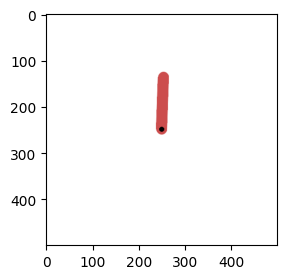

In [4]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(
            [action * 2])
        over = terminated or truncated

        #偏移reward,便于训练
        reward = (reward + 8) / 8

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [6]:
import torch


class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.s = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )

    def forward(self, state):
        return self.s(state)


model_action = Model()
model_action_delay = Model()
model_action_delay.load_state_dict(model_action.state_dict())

model_action(torch.randn(2, 3))

tensor([[-0.0572],
        [ 0.0147]], grad_fn=<TanhBackward0>)

In [8]:
model_value1 = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)
model_value1_delay = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)
model_value1_delay.load_state_dict(model_value1.state_dict())

model_value2 = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)
model_value2_delay = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)
model_value2_delay.load_state_dict(model_value2.state_dict())

model_value1(torch.randn(2, 4)), model_value2(torch.randn(2, 4))

(tensor([[-0.0669],
         [-0.0379]], grad_fn=<AddmmBackward0>),
 tensor([[-0.1608],
         [-0.2322]], grad_fn=<AddmmBackward0>))

  這就是 TD3 的第一個核心改動！
   * 我們不再只有一個評論家，而是創建了兩個結構完全一樣但相互獨立的評論家大腦：model_value1 和 model_value2。
   * 並且，我們為每一個評論家都創建了它們各自的「替身大腦」：model_value1_delay 和 model_value2_delay。
   * 所以，現在我們總共有 1 個演員、1 個演員替身、2 個評論家、2 個評論家替身，一共 6 個大腦在同時工作！

  👨‍💻 專業術語解說
  這個儲存格是 TD3 Clipped Double Q-Learning 的具體實現。
   1. Twin Critics: 程式碼明確定義了兩個獨立的 Critic 網路 model_value1 和
      model_value2。它們的網路結構完全相同，但由於權重是隨機初始化的，它們在訓練過程中會學習到略有差異的價值函數。
   2. Twin Target Critics: 同樣地，也為這兩個 Critic 分別創建了對應的目標網路 model_value1_delay 和 model_value2_delay。
   3. 獨立性: 這四個 Critic 相關的網路在參數層面上是完全獨立的，它們將在訓練中扮演不同的角色，共同實現對 Q 值的保守估計。

In [9]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = model_action(torch.FloatTensor(state).reshape(1, 3)).item()

        #给动作添加噪声,增加探索
        action += random.normalvariate(mu=0, sigma=0.2)

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

d:\it_project\github_sync\ml-workshop\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


38.97180512313724

In [10]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]

    #获取一批数据样本
    def sample(self):
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)
        action = torch.FloatTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 3)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
state, action, reward, next_state, over = pool.sample()

next_state.shape, len(pool), pool[0]

C:\Users\User\AppData\Local\Temp\ipykernel_62072\1738991660.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)


(torch.Size([64, 3]),
 200,
 (array([ 0.66211617,  0.7494012 , -0.99436915], dtype=float32),
  0.1720810221774542,
  0.8979161431963648,
  array([ 0.67626   ,  0.73666304, -0.38069397], dtype=float32),
  False))

In [11]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=5e-4)
optimizer_value1 = torch.optim.Adam(model_value1.parameters(), lr=5e-3)
optimizer_value2 = torch.optim.Adam(model_value2.parameters(), lr=5e-3)


def soft_update(_from, _to):
    for _from, _to in zip(_from.parameters(), _to.parameters()):
        value = _to.data * 0.99 + _from.data * 0.01
        _to.data.copy_(value)


def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)


requires_grad(model_action_delay, False)
requires_grad(model_value1_delay, False)
requires_grad(model_value2_delay, False)

In [12]:
def train_action(state):
    requires_grad(model_action, True)
    requires_grad(model_value1, False)
    requires_grad(model_value2, False)

    #首先把动作计算出来
    action = model_action(state)

    #使用value网络评估动作的价值,价值是越高越好
    input = torch.cat([state, action], dim=1)
    value1 = model_value1_delay(input)
    value2 = model_value2_delay(input)
    loss = -torch.min(value1, value2).mean()

    loss.backward()
    optimizer_action.step()
    optimizer_action.zero_grad()

    return loss.item()


train_action(state)

0.22576938569545746

In [13]:
def train_value(state, action, reward, next_state, over):
    requires_grad(model_action, False)
    requires_grad(model_value1, True)
    requires_grad(model_value2, True)

    #计算value
    input = torch.cat([state, action], dim=1)
    value1 = model_value1(input)
    value2 = model_value2(input)

    #计算target
    next_action = model_action_delay(next_state)
    input = torch.cat([next_state, next_action], dim=1)
    with torch.no_grad():
        target1 = model_value1_delay(input)
        target2 = model_value2_delay(input)
    target = torch.min(target1, target2)
    target = target * 0.99 * (1 - over) + reward

    #计算td loss,更新参数
    loss1 = torch.nn.functional.mse_loss(value1, target)
    loss2 = torch.nn.functional.mse_loss(value2, target)

    loss1.backward()
    optimizer_value1.step()
    optimizer_value1.zero_grad()

    loss2.backward()
    optimizer_value2.step()
    optimizer_value2.zero_grad()

    return loss1.item(), loss2.item(), value1.mean().item(), value2.mean().item()


train_value(state, action, reward, next_state, over)

(0.2848452031612396,
 0.34083086252212524,
 -0.1471780389547348,
 -0.13249078392982483)

In [14]:
#训练
def train():
    model_action.train()
    model_value1.train()
    model_value2.train()

    #共更新N轮数据
    for epoch in range(200):
        pool.update()

        #每次更新数据后,训练N次
        for i in range(200):

            #采样N条数据
            state, action, reward, next_state, over = pool.sample()

            #训练模型
            train_action(state)
            _, _, value1, value2 = train_value(state, action, reward,
                                               next_state, over)

            soft_update(model_action, model_action_delay)
            soft_update(model_value1, model_value1_delay)
            soft_update(model_value2, model_value2_delay)

        if epoch % 20 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, len(pool), value1, value2, test_result)


train()

0 400 0.2260240614414215 0.21259690821170807 8.661018536325786
20 4400 14.540691375732422 14.572338104248047 183.76999398104624
40 8400 41.53742218017578 41.56183624267578 176.74296907545087
60 12400 54.664886474609375 54.608795166015625 181.0078744909581
80 16400 58.68080139160156 58.67544174194336 178.62077622706232
100 20000 63.069400787353516 62.9329948425293 184.13429416508652
120 20000 64.12165832519531 64.04686737060547 179.3295991858124
140 20000 63.73664093017578 63.62254333496094 178.12823538226897
160 20000 65.0621109008789 65.2043228149414 183.5903686613885
180 20000 68.62338256835938 68.575439453125 182.71034522284964


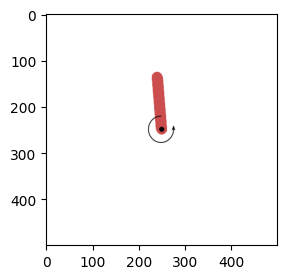

183.78421747275323

In [15]:
play(True)[-1]

╭────────────────────────────────────────────────────────────╮
│  > 所以重點是不僅僅依賴 model_delay，而是真的獨立訓練兩個  │
╰────────────────────────────────────────────────────────────╯

✦ 是的，您完全抓到重點了！這正是 TD3 中 "Twin" (雙生) 這個詞的精髓所在。

  我們可以這樣來區分 DDPG 和 TD3 的思想：

  ---

  DDPG 的做法：一個樂觀的評論家 + 一個「反應慢的自己」

   * 問題：DDPG 只有一個 model_value (評論家)。這個評論家在學習過程中，很容易變得「過度樂觀」，對某些動作給出不切實際的高分 (這就是 Q
     值過高估計問題)。
   * `model_delay` 的作用：DDPG 引入的 model_delay
     只是這個樂觀評論家的「一個反應比較慢的複製體」。它的作用是提供一個穩定的學習目標，避免主評論家在更新時「追逐自己變動的影子」。
   * 侷限：model_delay 雖然讓學習目標變穩定了，但它並沒有解決「過度樂觀」這個根本問題。如果主評論家是樂觀的，那麼它的延遲副本 model_delay
     同樣也是樂觀的。

  ---

  TD3 的做法：兩個獨立的評論家 + 悲觀的共識

  TD3 認為，要解決「過度樂觀」的問題，光有延遲是不夠的，你需要引入不同的觀點。

   1. 真正獨立訓練兩個 Critic:
       * model_value1 和 model_value2 是兩個完全獨立的網路。它們有相同的結構，但因為初始化的權重是隨機的，並且在每次訓練時抽樣的數據批次也可能
         帶來細微差異，它們會學到兩個略有不同的價值函數。
       * 您可以把它們想像成兩位獨立的、同樣專業的電影評論家。他們看同樣的電影（數據），但最終的影評（Q值估計）會有些許差異。

   2. 取兩者中的最小值:
       * 這是最關鍵的一步。在計算「標準答案」(TD Target) 時，TD3
         會同時問這兩位評論家（的替身）對下一個狀態的看法，然後選擇那個更悲觀、更保守的（即較低的）分數作為最終的學習目標。
       * target = r + gamma * min(Q'_1, Q'_2)

  為什麼這樣有效？

  因為一個評論家偶然出錯、給出離譜高分的機率是存在的。但是，兩個獨立的評論家，在同一時間、對同一個動作，同時給出離譜高分的機率，就大大降低了
  。

  通過取兩者中的最小值，TD3 能非常有效地抑制這種偶然的、虛高的價值估計，得到一個更接近真實情況、更可靠的學習目標。

  總結:

  您說的完全正確。TD3 的核心不僅僅是 delay（延遲更新），更是 Twin（雙生網路）和 min（取最小值）的結合。

   * `delay` 解決的是學習目標不穩定的問題。
   * `Twin` + `min` 解決的是學習目標不準確（過高估計） 的問題。

  TD3 把這兩者結合起來，才造就了它遠超 DDPG 的穩定性和性能。